# Optimal ridge penalty for real-world high-dimensional data can be zero or negative due to the implicit ridge regularization

https://arxiv.org/abs/1805.10939

In [1]:
# Load libraries and set up the notebook

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns
import matplotlib
import pickle

def sns_styleset():
    sns.set(context='paper', style='ticks', font='DejaVu Sans')
    matplotlib.rcParams['figure.dpi']        = 125
    matplotlib.rcParams['axes.linewidth']    = .75
    matplotlib.rcParams['xtick.major.width'] = .75
    matplotlib.rcParams['ytick.major.width'] = .75
    matplotlib.rcParams['xtick.major.size']  = 3
    matplotlib.rcParams['ytick.major.size']  = 3
    matplotlib.rcParams['xtick.minor.size']  = 2
    matplotlib.rcParams['ytick.minor.size']  = 2
    matplotlib.rcParams['font.size']         = 7
    matplotlib.rcParams['axes.titlesize']    = 7
    matplotlib.rcParams['axes.labelsize']    = 7
    matplotlib.rcParams['legend.fontsize']   = 7
    matplotlib.rcParams['xtick.labelsize']   = 7
    matplotlib.rcParams['ytick.labelsize']   = 7
    
sns_styleset()

## `Liver.toxicity` case study

Run `getData.R` in R to get the `.txt` files with data.

X shape: (64, 3116)
Y shape: (64, 10)


<IPython.core.display.Javascript object>


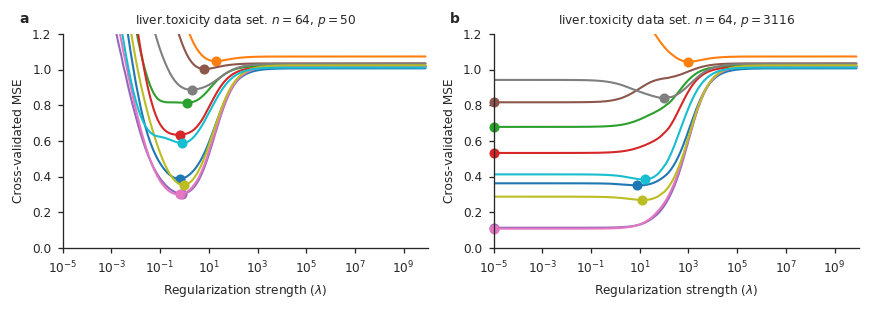

..........
..........
CPU times: user 46.6 s, sys: 416 ms, total: 47 s
Wall time: 19 s


In [7]:
%%time

# Using glmnet from https://web.stanford.edu/~hastie/glmnet_python/

import glmnet_python    
from cvglmnet import cvglmnet
from cvglmnetPlot import cvglmnetPlot

X = np.loadtxt('livertoxicity-gene.txt')
Y = np.loadtxt('livertoxicity-clinic.txt')
print('X shape:', X.shape)
print('Y shape:', Y.shape)

np.random.seed(42)
X = X[:, np.random.permutation(X.shape[1])]
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)
Y = Y - np.mean(Y, axis=0)
Y = Y / np.std(Y, axis=0)

# Making this a function because we will run it again below
def makefigure1(X, Y):
    lambdau = np.array(10.0**np.arange(-5,10,.1))
    ps = [50, X.shape[1]]

    plt.figure(figsize=(7,2.5))

    for subplotnum, p in enumerate(ps):
        plt.subplot(1,2,subplotnum+1)
    
        for i in range(Y.shape[1]):
            print('.', end='')
            y = Y[:,i]
            fit = cvglmnet(x = X[:,:p].copy(), y = y.copy(), alpha = 0, 
                           standardize = False, intr = True, lambdau=lambdau)
    
            color = next(plt.gca()._get_lines.prop_cycler)['color']
            plt.plot(fit['lambdau'], fit['cvm'], '-', color=color)
            plt.plot(fit['lambda_min'], np.min(fit['cvm']), 'o', color=color, clip_on=False)
        print('')

        plt.xlabel('Regularization strength ($\lambda$)')
        plt.ylabel('Cross-validated MSE')
        plt.title('liver.toxicity data set. $n=64$, $p=' + str(p) + '$')
        plt.xscale('log')
        plt.ylim([0, 1.2])
        plt.xlim([10**-5,10**10])
        sns.despine()

    plt.tight_layout()
    plt.text(-.12, 1.05, 'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=8, fontweight='bold')
    plt.text(-.12, 1.05, 'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=8, fontweight='bold')

makefigure1(X,Y)
plt.savefig('figures/livertoxicity.pdf')

<IPython.core.display.Javascript object>


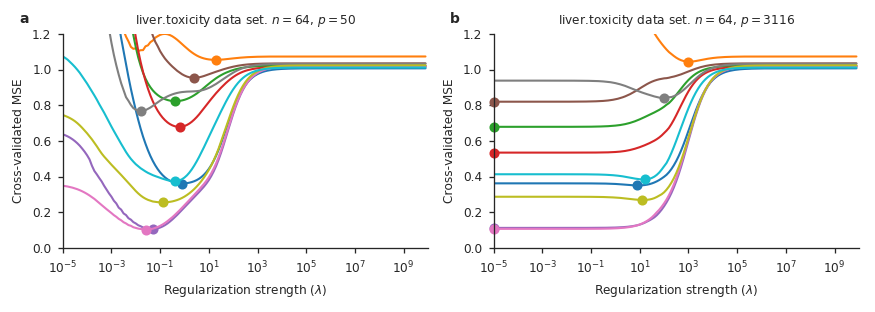

..........
..........
CPU times: user 54.3 s, sys: 528 ms, total: 54.8 s
Wall time: 27 s


In [8]:
%%time

# The same but using 50 predictors with the highest variance instead of 50 random predictors

X = np.loadtxt('livertoxicity-gene.txt')

X = X[:, np.argsort(np.std(X,axis=0))[::-1]]
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)

makefigure1(X,Y)

<IPython.core.display.Javascript object>


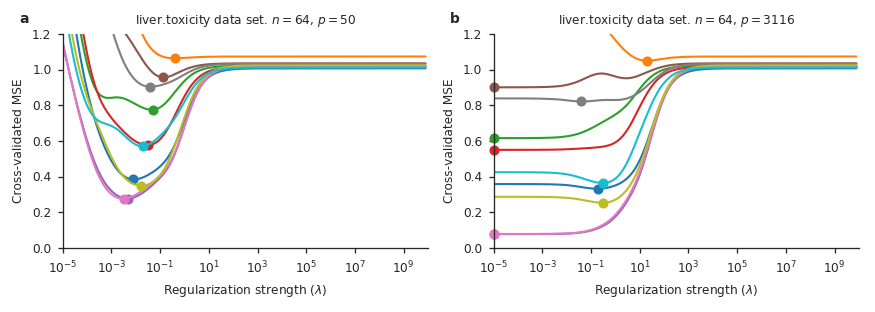

..........
..........
CPU times: user 54.4 s, sys: 468 ms, total: 54.9 s
Wall time: 22.1 s


In [9]:
%%time

# The same but without standardizing the predictors

X = np.loadtxt('livertoxicity-gene.txt')

np.random.seed(42)
X = X[:, np.random.permutation(X.shape[1])]
X = X - np.mean(X, axis=0)

makefigure1(X,Y)

## Toy model

In [20]:
def toymodelmse(n=64, ps=50, rho=0.1, snr=10, nrep=100, lambdau=1, seed=42, 
                verbose=2, normalize=True):
        
    if isinstance(ps, list):
        ps = np.array(ps)
    if not isinstance(ps, np.ndarray):
        ps = np.array([ps])
        
    if isinstance(lambdau, list):
        lambdau = np.array(lambdau)
    if not isinstance(lambdau, np.ndarray):
        lambdau = np.array([lambdau])

    np.random.seed(seed)
    expected_mse = np.zeros((ps.size, lambdau.size))
            
    for pnum, p in enumerate(ps):
    
        # set up the model in dimensionality p
        sigma = np.eye(p) + np.ones((p,p)) * rho
        cholesky_sigma = np.linalg.cholesky(sigma).T
        w = np.ones((p,1)) / np.sqrt((1+p*rho)*p) * np.sqrt(snr)
                
        mse = np.zeros((nrep, lambdau.size))
        for r in range(nrep):
            if verbose==2:
                print('.', end='')
            
            # generate training data on repetition r
            Xtrain = np.random.randn(n,p) @ cholesky_sigma
            ytrain = Xtrain @ w + np.random.randn(n,1)
        
            # SVD of the training data to quickly solve ridge regression
            [U,s,V] = np.linalg.svd(Xtrain, full_matrices = False)
            V = V.T
            
            # ridge estimators with various lambdas
            for i,l in enumerate(lambdau):
                beta = V @ np.diag(s/(s**2 + l)) @ U.T @ ytrain
                mse[r, i] = ((beta-w).T @ sigma @ (beta-w) + 1)
                if normalize:
                    mse[r,i] /= (snr + 1)

        if verbose==2:
            print('')
        if verbose==1:
            print('.', end='')
    
        expected_mse[pnum, :] = np.mean(mse, axis=0)
    
    if verbose==1:
        print('')
    
    return expected_mse

In [75]:
%%time

nrep = 100

ps = [50, 75, 150, 1000]
lambdau = 10.0**np.arange(-5,10,.1)
%time expected_mse = toymodelmse(ps=ps, lambdau=lambdau, nrep=nrep)
print('')

ps_scan = np.concatenate((np.arange(10,80), np.geomspace(80,1000,num=50).round().astype(int)))
lambdau_scan = np.arange(-200, 100)
%time expected_mse_scan = toymodelmse(ps=ps_scan, lambdau=lambdau_scan, nrep=nrep, verbose=1)
print('')

lambdau_aroundzero = np.arange(-500,1000,10)
%time expected_mse_aroundzero = toymodelmse(ps=1000, lambdau=lambdau_aroundzero, nrep=nrep)
print('')

pickle.dump([ps,lambdau,expected_mse, 
             ps_scan,lambdau_scan,expected_mse_scan, 
             lambdau_aroundzero, expected_mse_aroundzero],
            open('pickles/fig-toy.pickle', 'wb'))

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
CPU times: user 3min 12s, sys: 14 s, total: 3min 26s
Wall time: 27.3 s

........................................................................................................................
CPU times: user 1h 9min 57s, sys: 1min 48s, total: 1h 11min 46s
Wall time: 9min 20s

....................................................................................................
CPU times: user 2min 28s, sys: 3.66 s, total: 2min 32s
Wall time: 19.3 s

CPU times: user 1h 15min 39s, sys: 2min 6s, total: 1h 17min 45s
Wall time: 10min 7s


In [21]:
[ps,lambdau,expected_mse, ps_scan,lambdau_scan,expected_mse_scan,
 lambdau_aroundzero,expected_mse_aroundzero] = pickle.load(open('pickles/fig-toy.pickle', 'rb'))

<IPython.core.display.Javascript object>


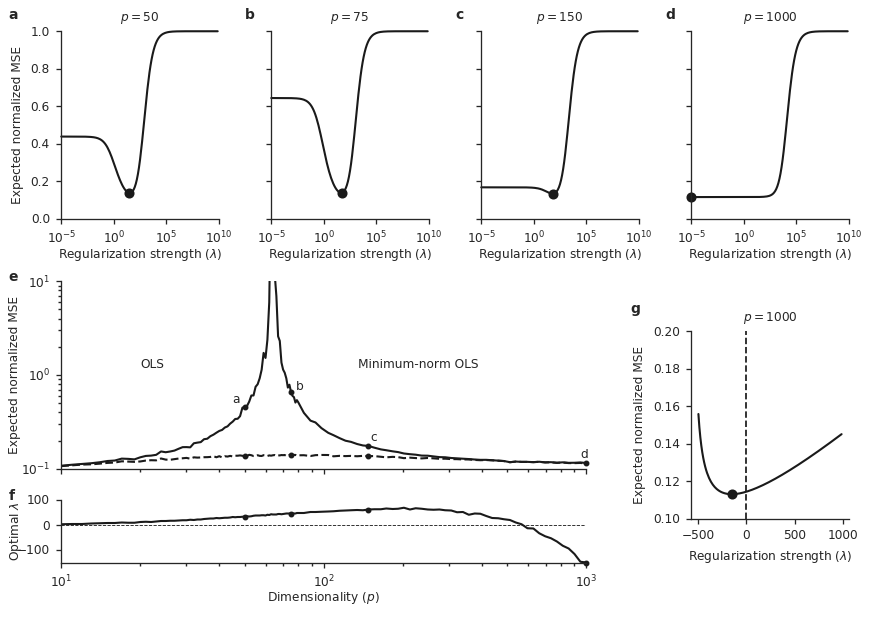

In [28]:
fig = plt.figure(figsize=(7, 5))
axs = []

################### panels a-d #######################

for i, p in enumerate(ps):
    ax = plt.axes([.07+i*.24, .65, .18, .3])
    axs.append(ax)
    
    plt.plot(lambdau, expected_mse[i,:], color='k', clip_on=False)
    plt.plot(lambdau[np.argmin(expected_mse[i,:])], np.min(expected_mse[i,:]), 'o', color='k', clip_on=False)
    plt.xscale('log')
    
    plt.title('$p=' + str(p) + '$')
    if i==0:
        plt.ylabel('Expected normalized MSE')
    else:
        plt.gca().axes.yaxis.set_ticklabels([])
    plt.xlabel('Regularization strength ($\lambda$)', labelpad=0)
    plt.ylim([0, 1])
    plt.xlim([10**-5,10**10])
    plt.xticks([10**-5, 10**0, 10**5, 10**10])


#################### panel e ##########################

ax = plt.axes([.07,.25,.6,.3])
axs.append(ax)

plt.plot(ps_scan, expected_mse_scan[:,lambdau_scan==0], 'k')
plt.plot(ps_scan, np.min(expected_mse_scan, axis=1), 'k--', zorder=0)

plt.ylabel('Expected normalized MSE', labelpad=0)
plt.yscale('log')
plt.xscale('log')
plt.ylim([0.1, 10])
plt.xlim([10,1000])
ax.tick_params(labelbottom=False)

for p in [50,75,148]:
    y1 = expected_mse_scan[ps_scan==p,:][:,lambdau_scan==0]
    y2 = np.min(expected_mse_scan[ps_scan==p,:])
    plt.plot(p, y2, 'k.')
    plt.plot(p, y1, 'k.')
plt.plot(1000, expected_mse_scan[ps_scan==1000,:][:,lambdau_scan==0], 'k.', clip_on=False)
    
plt.text(20,1.2, 'OLS', fontsize=7)
plt.text(135,1.2, 'Minimum-norm OLS', fontsize=7)
plt.text(45,.5, 'a', fontsize=7)
plt.text(78,.7, 'b', fontsize=7)
plt.text(150,.2, 'c', fontsize=7)
plt.text(950,.13, 'd', fontsize=7)


#################### panel f ##########################

ax = plt.axes([.07,.1,.6,.1])
axs.append(ax)

plt.plot([10,1000], [0,0], 'k--', linewidth=.5, zorder=0)
y = lambdau_scan[np.argmin(expected_mse_scan,axis=1)]
plt.plot(ps_scan, y, 'k')
for p in [50,75,148,1000]:
    plt.plot(p, y[ps_scan==p], 'k.', clip_on=False)

plt.xlabel('Dimensionality ($p$)', labelpad=0)
plt.ylabel('Optimal $\lambda$', labelpad=-4)
plt.xscale('log')
plt.ylim([-150, 100])
plt.yticks([-100,0,100])
plt.xlim([10,1000])


##################### panel g ##########################

ax = plt.axes([.07+3*.24, .17, .18, .3])
axs.append(ax)

plt.plot(lambdau_aroundzero, expected_mse_aroundzero[0,:], color='k')
plt.plot(lambdau_aroundzero[np.argmin(expected_mse_aroundzero[0,:])], 
         np.min(expected_mse_aroundzero[0,:]), 'o', color='k', clip_on=False)
    
plt.title('$p=1000$')
plt.ylabel('Expected normalized MSE')
plt.xlabel('Regularization strength ($\lambda$)')
plt.ylim([.1, .2])
plt.plot([0,0], [.1, .2], 'k--', linewidth=1)
plt.xticks([-500,0,500,1000])

########################################################

sns.despine()

fig.text(0.01, .97, 'a', fontsize=8, fontweight='bold')
fig.text(0.28, .97, 'b', fontsize=8, fontweight='bold')
fig.text(0.52, .97, 'c', fontsize=8, fontweight='bold')
fig.text(0.76, .97, 'd', fontsize=8, fontweight='bold')
fig.text(0.01, .55, 'e', fontsize=8, fontweight='bold')
fig.text(0.01, .20, 'f', fontsize=8, fontweight='bold')
fig.text(0.72, .50, 'g', fontsize=8, fontweight='bold')

plt.savefig('figures/toy.pdf')

In [75]:
print('Optimal lambda for p=1000:', lambdau_scan[np.argmin(expected_mse_scan[-1,:])])

Optimal lambda for p=1000: -150


## Scanning for optimal lambdas

In [149]:
%%time

nrep = 100

ns_scan = np.arange(10,101,10)
ps_scan = np.arange(20,1001,20)
lambdau_scan = np.arange(-500, 501, 25)
rhos_scan = [0,.05,.1,.2]

mses = {}
for rho in rhos_scan:
    print('rho = {}'.format(rho))
    
    mses[rho] = np.zeros((ps_scan.size, lambdau_scan.size, ns_scan.size))
    for i,n in enumerate(ns_scan):
        print(n, end=' ')
        mse = toymodelmse(n=n, ps=ps_scan, rho=rho, lambdau=lambdau_scan, nrep=nrep, verbose=1)
        mses[rho][:,:,i] = mse
        
    print('')
        
pickle.dump([ns_scan, ps_scan, lambdau_scan, rhos_scan, mses],
            open('pickles/scan2d.pickle', 'wb'))

rho = 0
10 ..................................................
20 ..................................................
30 ..................................................
40 ..................................................
50 ..................................................
60 ..................................................
70 ..................................................
80 ..................................................
90 ..................................................
100 ..................................................

rho = 0.05
10 ..................................................
20 ..................................................
30 ..................................................
40 ..................................................
50 ..................................................
60 ..................................................
70 ..................................................
80 ..................................................
90 ....

In [2]:
ns_scan, ps_scan, lambdau_scan, rhos_scan, mses = pickle.load(open('pickles/scan2d.pickle', 'rb'))

<IPython.core.display.Javascript object>


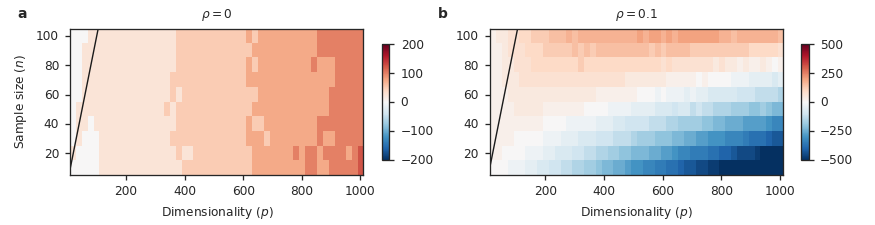

In [3]:
fig = plt.figure(figsize=(7,1.8))

vm = [200,500]
cbarticks = [[-200,-100,0,100,200], [-500,-250,0,250,500]]

for i, rho in enumerate([0,.1]):
    optLambda = lambdau_scan[np.argmin(mses[rho], axis=1)].squeeze()

    plt.subplot(1,2,i+1)
    
    plt.imshow(optLambda.T, interpolation='nearest', origin='lower', aspect=5,
           extent=[10,1010,5,105], 
           cmap='RdBu_r', vmin=-vm[i], vmax=vm[i])
    plt.colorbar(shrink=.65, aspect=15, ticks=cbarticks[i])
    
    plt.plot(np.arange(0,1100), np.arange(0,1100), 'k', linewidth=.8)
    plt.xlabel('Dimensionality ($p$)')
    if i==0:
        plt.ylabel('Sample size ($n$)')
    plt.ylim([5,105])
    plt.xlim([10,1010])
    plt.title(r'$\rho={}$'.format(rho))

plt.tight_layout()

fig.text(0.02, .92, 'a', fontsize=8, fontweight='bold')
fig.text(0.50, .92, 'b', fontsize=8, fontweight='bold')

plt.savefig('figures/optlambdas.pdf')

<IPython.core.display.Javascript object>


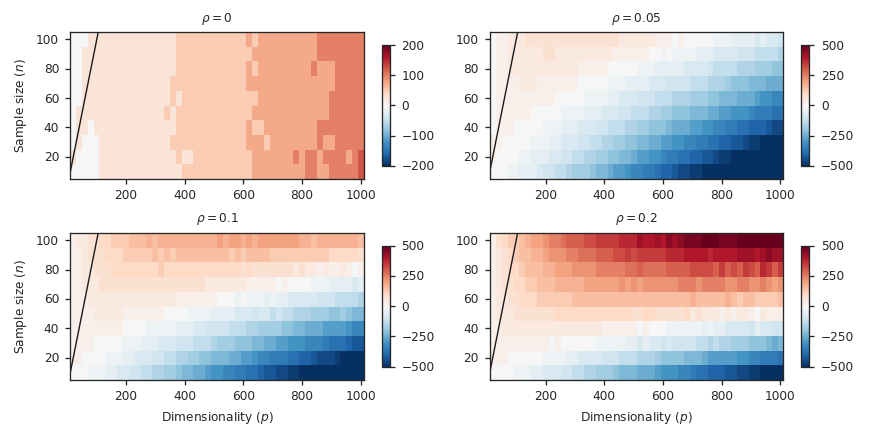

In [31]:
plt.figure(figsize=(7,3.5))

vm = [200,500,500,500]

for i, rho in enumerate(rhos_scan):
    optLambda = lambdau_scan[np.argmin(mses[rho], axis=1)].squeeze()

    plt.subplot(2,2,i+1)
    
    plt.imshow(optLambda.T, interpolation='none', origin='lower', aspect=5,
           extent=[10,1010,5,105], 
           cmap='RdBu_r', vmin=-vm[i], vmax=vm[i])
    plt.colorbar(shrink=.7, aspect=15)

    plt.plot(np.arange(0,1100), np.arange(0,1100), 'k', linewidth=.8)

    if i in [2,3]:
        plt.xlabel('Dimensionality ($p$)')
    if i in [0,2]:
        plt.ylabel('Sample size ($n$)')
    plt.ylim([5,105])
    plt.xlim([10,1010])
    plt.title(r'$\rho={}$'.format(rho))

plt.tight_layout()

## Augmenting the toy model with random predictors

In [4]:
# Set up the true model in p dimensions

p = 50
n = 64
rho = 0.1
snr = 10

sigma = np.eye(p) + np.ones((p,p)) * rho
cholesky_sigma = np.linalg.cholesky(sigma).T
w = np.ones((p,1)) / np.sqrt((1+p*rho)*p) * np.sqrt(snr)

In [5]:
%%time

# Ridge regression (for the first subplot)

nrep = 100

lambdau = np.array(10.0**np.arange(-5,10,.1))
np.random.seed(42)
    
mse_ridge = np.zeros((nrep, lambdau.size))
for r in range(nrep):
    print('.', end='')
    
    np.random.seed(r) # Will use this seed for training sets (same for all subplots)
    Xtrain = np.random.randn(n,p) @ cholesky_sigma
    ytrain = Xtrain @ w + np.random.randn(n,1)
    
    [U,s,V] = np.linalg.svd(Xtrain, full_matrices = False)
    V = V.T
    
    for i,l in enumerate(lambdau):
        beta = V @ np.diag(s/(s**2 + l)) @ U.T @ ytrain
        mse_ridge[r, i] = ((beta-w).T @ sigma @ (beta-w) + 1) / (w.T @ sigma @ w + 1)
print('')
mse_ridge = np.mean(mse_ridge, axis=0)

ridgebest = np.min(mse_ridge)
bestlambda = lambdau[np.argmin(mse_ridge)]
print('Optimal lambda: {:.2f}\n'.format(bestlambda))

....................................................................................................
Optimal lambda: 31.62

CPU times: user 8.08 s, sys: 101 ms, total: 8.18 s
Wall time: 1.06 s


In [7]:
%%time

# The following subplots are adding random predictors

nrep = 100

fakevar = np.array([np.nan, 1]) # NaN means adaptive variance = lambda/p
fakenum = np.arange(0, 401, 10)
lambdau_scan = np.arange(-200, 50, 5)

mse_fake = []
mse_fake_nontrunc = []

from scipy.linalg import block_diag

for sigma2 in fakevar:
    mse = np.zeros((nrep, fakenum.size, lambdau_scan.size))
    mse_nontrunc = np.zeros((nrep, fakenum.size, lambdau_scan.size))

    for r in range(nrep):
        print('.', end='')
        
        np.random.seed(r) # Will use this seed for training sets (same for all subplots)
        Xtrain = np.random.randn(n,p) @ cholesky_sigma
        ytrain = Xtrain @ w + np.random.randn(n,1)
    
        for i,pfake in enumerate(fakenum):
            if np.isnan(sigma2): 
                if pfake > 0:
                    fakestd = np.sqrt(bestlambda/pfake)
                else:
                    fakestd = 0
            else:
                fakestd = np.sqrt(sigma2)
                
            Xfake = np.random.randn(n, pfake) * fakestd
            [U,s,V] = np.linalg.svd(np.concatenate((Xtrain,Xfake), axis=1), full_matrices = False)
            V = V.T   
            
            for j,l in enumerate(lambdau_scan):
                beta = V @ np.diag(s/(s**2 + l)) @ U.T @ ytrain
                beta_trunc = beta[:p]
                mse[r, i, j] = ((beta_trunc-w).T @ sigma @ (beta_trunc-w) + 1) / (w.T @ sigma @ w + 1)
            
                w_extended = np.concatenate((w, np.zeros((pfake,1))))
                sigma_extended = block_diag(sigma, np.eye(pfake) * fakestd**2)
                mse_nontrunc[r, i, j] = ((beta-w_extended).T @ sigma_extended @ (beta-w_extended) 
                                  + 1) / (w.T @ sigma @ w + 1)
    print('')
    
    mse = np.mean(mse, axis=0).squeeze()
    mse_nontrunc = np.mean(mse_nontrunc, axis=0).squeeze()
    
    mse_fake.append(mse)
    mse_fake_nontrunc.append(mse_nontrunc)
    
pickle.dump([mse_fake, mse_fake_nontrunc, fakevar, fakenum, lambdau_scan],
            open('pickles/randompredictors.pickle', 'wb'))

....................................................................................................
....................................................................................................
CPU times: user 32min 54s, sys: 1min 53s, total: 34min 47s
Wall time: 4min 33s


In [32]:
[mse_fake, mse_fake_nontrunc, fakevar, fakenum, lambdau_scan] = \
        pickle.load(open('pickles/randompredictors.pickle', 'rb'))

<IPython.core.display.Javascript object>


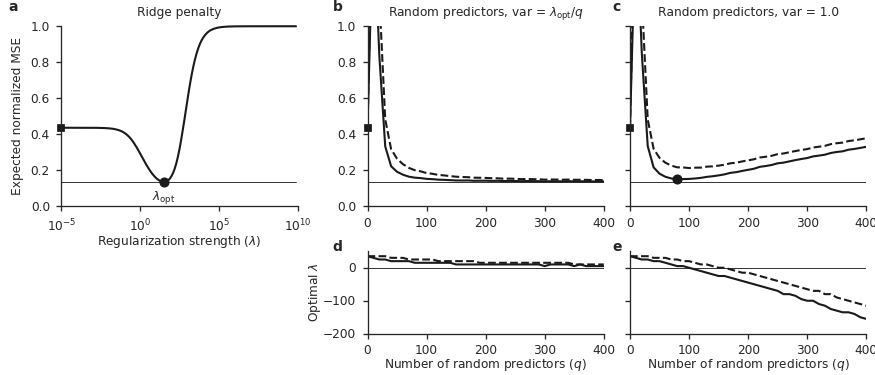

In [36]:
fig = plt.figure(figsize=(7,3))

plt.axes([.07,.45,.27,.48])
plt.plot(lambdau, mse_ridge, color='k', clip_on=False)
plt.text(bestlambda, ridgebest-.1, '$\lambda_\mathrm{opt}$', ha='center', fontsize=7)
plt.plot(bestlambda, ridgebest, 'o', color='k')
plt.plot(lambdau[0], mse_ridge[0], 's', markersize=3, color='k', clip_on=False)
plt.plot(plt.xlim(), [ridgebest,ridgebest], 'k', linewidth=.5)
plt.title('Ridge penalty')
plt.ylabel('Expected normalized MSE')
plt.xlabel('Regularization strength ($\lambda$)', labelpad=0)
plt.xscale('log')
plt.ylim([0, 1])
plt.xlim([10**-5,10**10])
plt.xticks([10**-5, 10**0, 10**5, 10**10])
    
for i in range(fakevar.size):
    plt.axes([.12+.3*(i+1),.45,.27,.48])
    plt.ylim([0, 1])
    plt.xlim([0, fakenum[-1]])
    plt.xticks([0,100,200,300,400])
    
    plt.plot(fakenum, mse_fake_nontrunc[i][:,lambdau_scan==0], '--', color='k')#, dashes=(5, 5))
    plt.plot(plt.xlim(), [ridgebest,ridgebest], 'k-', linewidth=.5)
    plt.plot(fakenum, mse_fake[i][:,lambdau_scan==0], color='k')
    if ~np.isnan(fakevar[i]):
        plt.plot(fakenum[np.argmin(mse_fake[i][:,lambdau_scan==0])], 
                 np.min(mse_fake[i][:,lambdau_scan==0]), 'o', color='k')
    plt.plot(0, mse_fake[i][:,lambdau_scan==0][0], 's', color='k', markersize=3, clip_on=False)
    
    if np.isnan(fakevar[i]):
        plt.title('Random predictors, var = $\lambda_\mathrm{opt}/q$')
    else:
        plt.title('Random predictors, var = {}'.format(fakevar[i]))
    if i>0:
        plt.gca().axes.yaxis.set_ticklabels([])


for i in range(fakevar.size):
    plt.axes([.12+.3*(i+1),.11,.27,.22])
    
    plt.ylim([-200, 50])
    plt.yticks([-200,-100,0])
    plt.xlim([0, fakenum[-1]])
    plt.xticks([0,100,200,300,400])
    if i==0:
        plt.ylabel('Optimal $\lambda$', labelpad=0)
    else:
        plt.gca().axes.yaxis.set_ticklabels([])
    plt.xlabel('Number of random predictors ($q$)', labelpad=0)
    
    plt.plot([-20, fakenum[-1]], [0,0], 'k', linewidth=.5)
    plt.plot(fakenum, lambdau_scan[np.argmin(mse_fake[i], axis=1)], 'k')
    plt.plot(fakenum, lambdau_scan[np.argmin(mse_fake_nontrunc[i], axis=1)], 'k--')
        
        
sns.despine()

fig.text(.01, .97, 'a', fontsize=8, fontweight='bold')
fig.text(.38, .97, 'b', fontsize=8, fontweight='bold')
fig.text(.70, .97, 'c', fontsize=8, fontweight='bold')
fig.text(.38, .33, 'd', fontsize=8, fontweight='bold')
fig.text(.70, .33, 'e', fontsize=8, fontweight='bold')

plt.savefig('figures/randompredictors.pdf')

## Analytical derivation of the derivative at zero

In [86]:
%%time

from numpy.linalg import norm

n = 64
rho = 0.1
snr = 10

nrep = 100
ps = np.arange(10,1001,10)
np.random.seed(42)

d = np.zeros((ps.size, nrep))
term1 = np.zeros((ps.size, nrep))
term2 = np.zeros((ps.size, nrep))
term3 = np.zeros((ps.size, nrep))
term4 = np.zeros((ps.size, nrep))

for i,p in enumerate(ps):
    print('.', end='')
    sigma = np.eye(p) + np.ones((p,p)) * rho
    cholesky_sigma = np.linalg.cholesky(sigma).T
    w = np.ones((p,1)) / np.sqrt((1+p*rho)*p) * np.sqrt(snr)

    for j in range(nrep):    
        X = np.random.randn(n,p) @ cholesky_sigma
        [U,s,V] = np.linalg.svd(X, full_matrices = False)
        V = V.T
        
        def P(k):
            return (w.T @ V @ np.diag(1/s**k) @ V.T @ w)[0][0]
        
        a = rho*p*(1+rho*p) / snr
        term1[i,j] = 2*a*norm(w)**2*P(2)
        term2[i,j] = 2*a*P(0)*P(2)
        term3[i,j] = 2*np.sum(1/s**4)
        term4[i,j] = 2*a*P(4)
        d[i,j] = term1[i,j]-term2[i,j]-term3[i,j]-term4[i,j]
print('')

....................................................................................................
CPU times: user 10min 39s, sys: 17.3 s, total: 10min 56s
Wall time: 1min 24s


<IPython.core.display.Javascript object>


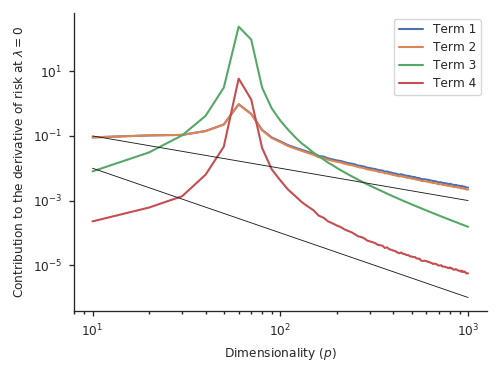

In [95]:
fig = plt.figure(figsize=(4,3))
plt.plot(ps, np.mean(term1, axis=1), label='Term 1')
plt.plot(ps, np.mean(term2, axis=1), label='Term 2')
plt.plot(ps, np.mean(term3, axis=1), label='Term 3')
plt.plot(ps, np.mean(term4, axis=1), label='Term 4')
plt.yscale('log')
plt.xscale('log')
plt.plot(ps, ps**-1.0, 'k', linewidth=.5)
plt.plot(ps, ps**-2.0, 'k', linewidth=.5)
plt.legend()
plt.xlabel('Dimensionality ($p$)')
plt.ylabel('Contribution to the derivative of risk at $\lambda=0$')

sns.despine()
plt.tight_layout()

<IPython.core.display.Javascript object>


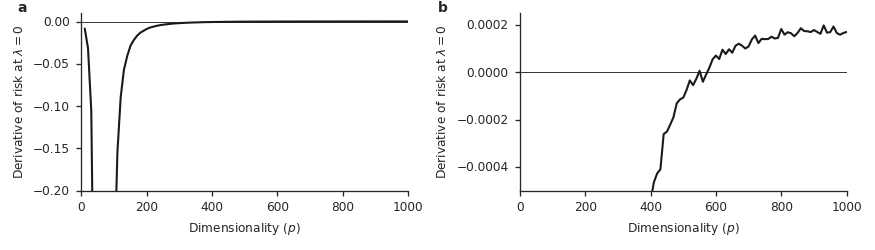

In [90]:
fig = plt.figure(figsize=(7,2))

plt.subplot(121)
plt.plot([0,1000], [0,0], 'k', linewidth=.5)
plt.plot(ps, np.mean(d, axis=1), 'k')
plt.ylim([-0.2, 0.01])
plt.xlim([0,1000])
plt.xlabel('Dimensionality ($p$)')
plt.ylabel('Derivative of risk at $\lambda=0$')

plt.subplot(122)
plt.plot(ps, np.mean(d, axis=1), 'k')
plt.ylim([-0.0005, 0.00025])
plt.xlim([0,1000])
plt.plot([0,1000], [0,0], 'k', linewidth=.5)
plt.xlabel('Dimensionality ($p$)')
plt.ylabel('Derivative of risk at $\lambda=0$')

sns.despine()
plt.tight_layout()

fig.text(.02, .95, 'a', fontsize=8, fontweight='bold')
fig.text(.50, .95, 'b', fontsize=8, fontweight='bold')

plt.savefig('figures/derivative.pdf')

## Random features on MNIST

In [96]:
# Load MNIST data

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
X = mnist.data
y = mnist.target.astype('int')
print(X.shape)

X = X/255*2 - 1

(70000, 784)


In [138]:
p = 1000
np.random.seed(42)
W = np.random.randn(784,p) / 10

test = np.arange(60000,70000)
X_rand_test = np.exp(-1j * X[test,:]@W)
X_rand_test = np.concatenate((np.real(X_rand_test), np.imag(X_rand_test)), axis=1)

In [203]:
%%time

nrep = 100
n = 64

lambdau1 = 10.0**np.arange(-3,11,.1)
lambdau2 = np.arange(-100, 100)
mse1 = np.zeros((lambdau1.size, nrep))
mse2 = np.zeros((lambdau2.size, nrep))
mineig = np.zeros(nrep)

np.random.seed(42)
for r in range(nrep):
    print('.', end='')
    train = np.random.choice(60000, size=n, replace=False)

    X_rand_train = np.exp(-1j * X[train,:]@W)
    X_rand_train = np.concatenate((np.real(X_rand_train), np.imag(X_rand_train)), axis=1)
    
    muX = np.mean(X_rand_train, axis=0)
    muY = np.mean(y[train])

    [U,s,V] = np.linalg.svd((X_rand_train-muX), full_matrices = False)
    V = V.T
    
    # Remove near-zero singular value due to centering
    # This eliminates a little noisy MSE spike at lambda=0
    s = s[:-1]
    U = U[:,:-1]
    V = V[:,:-1]
    
    mineig[r] = np.min(s)**2

    # ridge estimators with various lambdas
    for i,l in enumerate(lambdau1):
        beta = V @ np.diag(s/(s**2 + l)) @ U.T @ (y[train]-muY)
        mse1[i,r] = np.mean(((X_rand_test-muX) @ beta - (y[test]-muY))**2)
    
    for i,l in enumerate(lambdau2):
        beta = V @ np.diag(s/(s**2 + l)) @ U.T @ (y[train]-muY)
        mse2[i,r] = np.mean(((X_rand_test-muX) @ beta - (y[test]-muY))**2)
        
print('')

pickle.dump([lambdau1, lambdau2, mse1, mse2, mineig],
            open('pickles/mnist.pickle', 'wb'))

....................................................................................................
CPU times: user 28.6 s, sys: 1.56 s, total: 30.2 s
Wall time: 3.92 s


In [213]:
[lambdau1, lambdau2, mse1, mse2, mineig] = pickle.load(open('pickles/mnist.pickle', 'rb'))

<IPython.core.display.Javascript object>


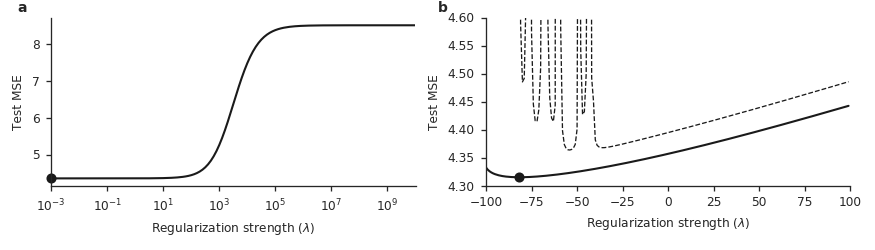

Number of random X draws with min(s**2)<100: 20


In [216]:
fig = plt.figure(figsize=(7,2))

plt.subplot(121)
mse = np.mean(mse1, axis=1)
plt.plot(lambdau1, mse, 'k-')
plt.plot(lambdau1[np.argmin(mse)], np.min(mse), 'o', color='k', clip_on=False)

plt.xscale('log')
plt.xlim([10**-3, 10**10])
plt.xlabel('Regularization strength ($\lambda$)')
plt.ylabel('Test MSE')

plt.subplot(122)
mse = np.mean(mse2[:, mineig>100], axis=1)
plt.plot(lambdau2, mse, 'k-')
plt.plot(lambdau2[np.argmin(mse)], np.min(mse), 'o', color='k', clip_on=False)

mse = np.mean(mse2[:, mineig<100], axis=1)
plt.plot(lambdau2, mse, 'k--', linewidth=.75)
print('Number of random X draws with min(s**2)<100: {}'.format(np.sum(mineig<100)))

plt.xlim([-100,100])
plt.ylim([4.3, 4.6])
plt.xlabel('Regularization strength ($\lambda$)')
plt.ylabel('Test MSE')

sns.despine()
plt.tight_layout()

fig.text(.02, .95, 'a', fontsize=8, fontweight='bold')
fig.text(.50, .95, 'b', fontsize=8, fontweight='bold')

plt.savefig('figures/mnist.pdf')